### ISC among twins and control analyses

The goal of this notebook is to measure ISC among twins and compare it against control-twins (i.e. age- and sex-matched controls) non-twins.

The hypothesis is that ISC for twin-pairs will be generally higher than for non-twin pairs (or controls). We will further concretize the control-analyses below and in the follow-up notebooks.

#### Import modules

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
import sys, os, nilearn, pickle, glob, shutil, itertools, random
from nilearn import plotting, input_data, datasets
import numpy as np
import pandas as pd
from statsmodels.stats.multitest import multipletests
from utils import *
import warnings
from tqdm import tqdm
warnings.simplefilter("ignore")
from nilearn.masking import compute_brain_mask, apply_mask
from nilearn import image

#!pip install surfplot
#!pip install neuromaps
#!pip install matplotlib --upgrade

n_regions       = 293


#### Reading in Twin-list and computing ISC among twins

In [22]:
twin_df = pd.read_csv('../data/00_dataset_info/twin_df.csv')

twin_list = twin_df[['twin_A_id','twin_B_id']].values.tolist()
print(twin_list[:3])

twin_df.head()

[['sub-0001', 'sub-0018'], ['sub-0003', 'sub-0233'], ['sub-0004', 'sub-0420']]


,Unnamed: 0,family_id,twin_A_id,twin_A_age,twin_A_sex,twin_B_id,twin_B_age,twin_B_sex
0,0,fam-0001,sub-0001,14.0,M,sub-0018,14.0,M
1,1,fam-0116,sub-0003,14.0,M,sub-0233,14.0,F
2,2,fam-0002,sub-0004,11.0,M,sub-0420,11.0,M
3,3,fam-0088,sub-0005,12.0,F,sub-0178,12.0,F
4,4,fam-0178,sub-0006,15.0,M,sub-0329,15.0,F


In [23]:
# Computing ISC (functional) for the real twins
n_twins         = len(twin_list)
iscs_reg_twin   = np.zeros((n_regions+1, n_twins)) #the additional line is for the anatomical similarity

for curr_region in tqdm(range(n_regions)):
    twin_iscs      = []
    
    for twin_pair in twin_list:
        filename_1 = '../data/03_extract_ts/' + twin_pair[0] + '_LTR_Z_THP001_LP012_shen268_pauli16_aan9.npy'
        twin1_data = np.load(filename_1) 
        filename_2 = '../data/03_extract_ts/' + twin_pair[1] + '_LTR_Z_THP001_LP012_shen268_pauli16_aan9.npy'
        twin2_data = np.load(filename_2) 
        
        twin_iscs.append(np.corrcoef(twin1_data[:,curr_region], twin2_data[:,curr_region])[0,1])
 
    iscs_reg_twin[curr_region, :]   = twin_iscs

    
#anatomical similarity
'''anatomical_similarity_twins = []
for twin_pair in tqdm(twin_list):
        file_a = twin_pair[0]
        file_b = twin_pair[1] 

        f1 = '../data/04_anatomy/' + file_a + '_ses-02_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'
        f1m = '../data/04_anatomy/' + file_a + '_ses-02_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
        f1_masked = apply_mask(f1, compute_brain_mask(f1m, threshold=0.01, mask_type='whole-brain'))

        f2 = '../data/04_anatomy/' + file_b + '_ses-02_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'
        f2m = '../data/04_anatomy/' + file_b + '_ses-02_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
        f2_masked = apply_mask(f2, compute_brain_mask(f2m, threshold=0.01, mask_type='whole-brain'))

        anatomical_similarity_twins.append(np.corrcoef(f1_masked, f2_masked)[0,1])

iscs_reg_twin[293,:] = np.asarray(anatomical_similarity_twins) #'''


100%|██████████| 293/293 [00:32<00:00,  9.05it/s]


"anatomical_similarity_twins = []\nfor twin_pair in tqdm(twin_list):\n        file_a = twin_pair[0]\n        file_b = twin_pair[1] \n\n        f1 = '../data/04_anatomy/' + file_a + '_ses-02_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'\n        f1m = '../data/04_anatomy/' + file_a + '_ses-02_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'\n        f1_masked = apply_mask(f1, compute_brain_mask(f1m, threshold=0.01, mask_type='whole-brain'))\n\n        f2 = '../data/04_anatomy/' + file_b + '_ses-02_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'\n        f2m = '../data/04_anatomy/' + file_b + '_ses-02_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'\n        f2_masked = apply_mask(f2, compute_brain_mask(f2m, threshold=0.01, mask_type='whole-brain'))\n\n        anatomical_similarity_twins.append(np.corrcoef(f1_masked, f2_masked)[0,1])\n\niscs_reg_twin[293,:] = np.asarray(anatomical_similarity_twins) #"

#### Reading in ControlTwin-List and computing ISC among control-twins

In [24]:
controltwin_df = pd.read_csv('../data/00_dataset_info/matched_controltwin_df.csv')

controltwin_list = controltwin_df[['twin_A_id','controltwin_B_id']].values.tolist()
print(controltwin_list[:3])

controltwin_df.head()

[['sub-0001', 'sub-0003'], ['sub-0004', 'sub-0151'], ['sub-0005', 'sub-0043']]


,family_id,twin_A_id,twin_A_age,twin_A_sex,controlfamily_id,controltwin_B_id,controltwin_B_age,controltwin_B_sex
0,fam-0001,sub-0001,14,M,fam-0116,sub-0003,14,M
1,fam-0002,sub-0004,11,M,fam-0038,sub-0151,11,M
2,fam-0088,sub-0005,12,F,fam-0151,sub-0043,12,F
3,fam-0178,sub-0006,15,M,fam-0007,sub-0017,15,M
4,fam-0003,sub-0007,10,F,fam-0137,sub-0261,10,F


In [25]:
# Computing ISC for the real twins
n_controltwins       = len(twin_list)
iscs_reg_controltwin = np.zeros((n_regions+1, n_controltwins))

for curr_region in tqdm(range(n_regions)):
    controltwin_iscs = []
    
    for controltwin_pair in controltwin_list:
        filename_1 = '../data/03_extract_ts/' + controltwin_pair[0] + '_LTR_Z_THP001_LP012_shen268_pauli16_aan9.npy'
        controltwin1_data = np.load(filename_1) 
        filename_2 = '../data/03_extract_ts/' + controltwin_pair[1] + '_LTR_Z_THP001_LP012_shen268_pauli16_aan9.npy'
        controltwin2_data = np.load(filename_2) 
        
        controltwin_iscs.append(np.corrcoef(controltwin1_data[:,curr_region], controltwin2_data[:,curr_region])[0,1])
 
    iscs_reg_controltwin[curr_region, :]   = controltwin_iscs
    

#anatomical similarity
'''anatomical_similarity_controltwins = []
for controltwin_pair in tqdm(controltwin_list):
        file_a = controltwin_pair[0]
        file_b = controltwin_pair[1] 

        f1  = '../data/04_anatomy/' + file_a + '_ses-02_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'
        f1m = '../data/04_anatomy/' + file_a + '_ses-02_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
        f1_masked = apply_mask(f1, compute_brain_mask(f1m, threshold=0.01, mask_type='whole-brain'))

        f2  = '../data/04_anatomy/' + file_b + '_ses-02_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'
        f2m = '../data/04_anatomy/' + file_b + '_ses-02_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
        f2_masked = apply_mask(f2, compute_brain_mask(f2m, threshold=0.01, mask_type='whole-brain'))

        anatomical_similarity_controltwins.append(np.corrcoef(f1_masked, f2_masked)[0,1])

iscs_reg_controltwin[293,:] = np.asarray(anatomical_similarity_controltwins) #'''


100%|██████████| 293/293 [00:32<00:00,  9.00it/s]


"anatomical_similarity_controltwins = []\nfor controltwin_pair in tqdm(controltwin_list):\n        file_a = controltwin_pair[0]\n        file_b = controltwin_pair[1] \n\n        f1  = '../data/04_anatomy/' + file_a + '_ses-02_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'\n        f1m = '../data/04_anatomy/' + file_a + '_ses-02_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'\n        f1_masked = apply_mask(f1, compute_brain_mask(f1m, threshold=0.01, mask_type='whole-brain'))\n\n        f2  = '../data/04_anatomy/' + file_b + '_ses-02_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'\n        f2m = '../data/04_anatomy/' + file_b + '_ses-02_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'\n        f2_masked = apply_mask(f2, compute_brain_mask(f2m, threshold=0.01, mask_type='whole-brain'))\n\n        anatomical_similarity_controltwins.append(np.corrcoef(f1_masked, f2_masked)[0,1])\n\niscs_reg_controltwin[293,:] = np.asarray(anatomical_similarity_controltwins) #"

#### Computing ISC among random people

In [26]:
iscs_reg_notwin = np.zeros((n_regions+1, n_twins))

for curr_region in tqdm(range(n_regions)):
    no_twin_iscs      = []

    for twin_pair in twin_list:
        filename_1 = '../data/03_extract_ts/' + twin_pair[0] + '_LTR_Z_THP001_LP012_shen268_pauli16_aan9.npy'
        twin1_data = np.load(filename_1) 

        #from the remaining people, randomly chose one, excluding the actual twin
        other_twin_list = twin_df['twin_B_id'].values.tolist()
        other_people = [x for x in other_twin_list if x != twin_pair[1]]  
        no_twin_filename_1 = '../data/03_extract_ts/' + random.choice(other_people) + '_LTR_Z_THP001_LP012_shen268_pauli16_aan9.npy'
        no_twin_data1 = np.load(no_twin_filename_1) 

        no_twin_iscs.append(np.corrcoef(twin1_data[:,curr_region], no_twin_data1[:,curr_region])[0,1])

    iscs_reg_notwin[curr_region, :] = no_twin_iscs
    
    
#anatomical similarity
'''anatomical_similarity_notwins = []
for notwin_pair in tqdm(twin_list):
        file_a = notwin_pair[0]
        file_b = notwin_pair[1] 

        f1  = '../data/04_anatomy/' + file_a + '_ses-02_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'
        f1m = '../data/04_anatomy/' + file_a + '_ses-02_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
        f1_masked = apply_mask(f1, compute_brain_mask(f1m, threshold=0.01, mask_type='whole-brain'))

        f2  = '../data/04_anatomy/' + file_b + '_ses-02_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'
        f2m = '../data/04_anatomy/' + file_b + '_ses-02_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
        f2_masked = apply_mask(f2, compute_brain_mask(f2m, threshold=0.01, mask_type='whole-brain'))

        anatomical_similarity_notwins.append(np.corrcoef(f1_masked, f2_masked)[0,1])

iscs_reg_notwin[293,:] = np.asarray(anatomical_similarity_notwins) #'''


100%|██████████| 293/293 [00:36<00:00,  8.08it/s]


"anatomical_similarity_notwins = []\nfor notwin_pair in tqdm(twin_list):\n        file_a = notwin_pair[0]\n        file_b = notwin_pair[1] \n\n        f1  = '../data/04_anatomy/' + file_a + '_ses-02_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'\n        f1m = '../data/04_anatomy/' + file_a + '_ses-02_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'\n        f1_masked = apply_mask(f1, compute_brain_mask(f1m, threshold=0.01, mask_type='whole-brain'))\n\n        f2  = '../data/04_anatomy/' + file_b + '_ses-02_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'\n        f2m = '../data/04_anatomy/' + file_b + '_ses-02_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'\n        f2_masked = apply_mask(f2, compute_brain_mask(f2m, threshold=0.01, mask_type='whole-brain'))\n\n        anatomical_similarity_notwins.append(np.corrcoef(f1_masked, f2_masked)[0,1])\n\niscs_reg_notwin[293,:] = np.asarray(anatomical_similarity_notwins) #"

#### Compute averages and plot

In [27]:
reg_mean_twin_iscs        = np.mean(iscs_reg_twin, axis = 1)
reg_mean_controltwin_iscs = np.mean(iscs_reg_controltwin, axis = 1)
reg_mean_notwin_iscs      = np.mean(iscs_reg_notwin, axis = 1)

print(reg_mean_twin_iscs.shape)
print(reg_mean_controltwin_iscs.shape)
print(reg_mean_notwin_iscs.shape)

(294,)
(294,)
(294,)


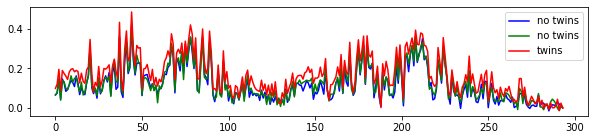

In [28]:
plt.figure(figsize = (10,2));
plt.plot(reg_mean_notwin_iscs, color = 'blue', label='no twins');
plt.plot(reg_mean_controltwin_iscs, color = 'green', label='no twins');
plt.plot(reg_mean_twin_iscs, color = 'red', label='twins');
plt.legend();

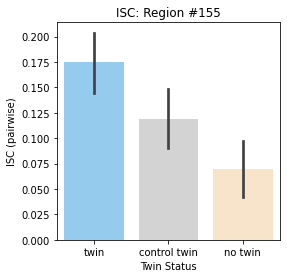

In [96]:
current_region_index = 155
#293 is anatomical_similarity


df0 = pd.DataFrame(np.vstack(( iscs_reg_notwin[current_region_index,:], 
                   len(iscs_reg_notwin[current_region_index,:]) * ['no twin'] )).T, 
                  columns = ['ISC','Twin Status'])

df1 = pd.DataFrame(np.vstack(( iscs_reg_controltwin[current_region_index,:], 
                   len(iscs_reg_controltwin[current_region_index,:]) * ['control twin'] )).T, 
                   columns = ['ISC','Twin Status'])

df2 = pd.DataFrame(np.vstack(( iscs_reg_twin[current_region_index,:], 
                   len(iscs_reg_twin[current_region_index,:]) * ['twin'] )).T, 
                   columns = ['ISC','Twin Status'])

result_df = pd.concat([df2, df1, df0])
del df1, df2, df0

result_df['ISC'] = result_df['ISC'].astype('float')

plt.figure(figsize =  (4,4))
sns.barplot(data=result_df, 
            x="Twin Status", 
            y="ISC",
            palette = [ 'lightskyblue','lightgrey','bisque']).set(title='ISC: Region #' + str(current_region_index));
#plt.ylim([0.6, 0.8])
plt.ylabel('ISC (pairwise)');

In [13]:
result_df.to_csv('../data/05_results/twin_isc_df.csv')

# 
So, up to here we have shown that 

- at least nominally, ISC among twins is stronger than among non-twins.
- from first glance, it appears that this is a relatively global effect, i.e. ISC seems consistently elevated throughout the brain, not just in a single region.
- tentative interpretation: it could be a general 'attentional' effect.
- seeing the world in the same way? 


Next steps: 
- run statistics
- examine if some regions stand out
- examine e.g. if this is demonstrable for all age groups.
- examine if this could be explained e.g. by anatomical differences ...



In [17]:
diffs[:292].shape

(292,)

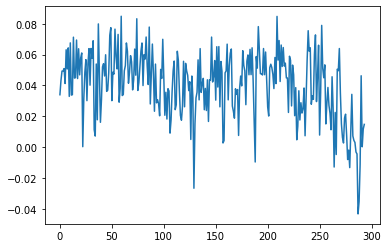

In [18]:
diffs = reg_mean_twin_iscs - reg_mean_controltwin_iscs
plt.plot(diffs);

from nilearn import input_data, datasets
all293_rois_file       = '../data/02_rois_masks_maps/allcombined.nii'
all293_masker = input_data.NiftiLabelsMasker(all293_rois_file, 
                                             detrend     = True, 
                                             standardize = True,
                                             high_pass   = 0.01, 
                                             t_r         = 0.8, 
                                             low_pass    = 0.12 );
all293_masker.fit('../data/02_rois_masks_maps/sub-0001_ses-02_task-partlycloudy_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
brainisc = all293_masker.inverse_transform(np.reshape(diffs[:293], (1,293))) #drop last element because that's just anatomy


<Figure size 720x432 with 0 Axes>

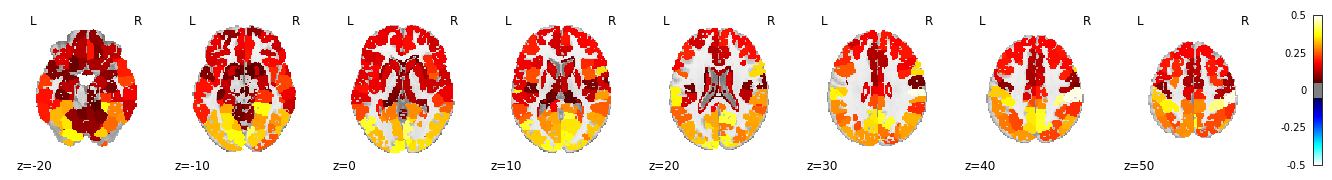

<Figure size 720x432 with 0 Axes>

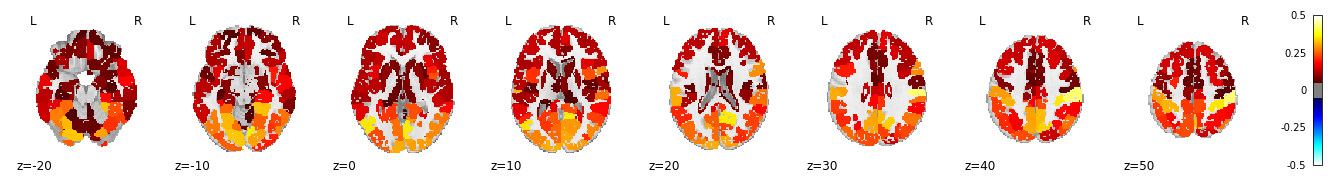

<Figure size 720x432 with 0 Axes>

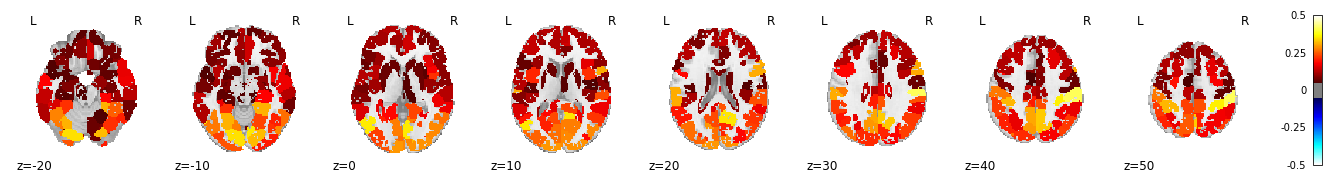

In [36]:
curr_isc = np.reshape(reg_mean_twin_iscs[:293] , (293,1)).T
curr_img = all293_masker.inverse_transform(curr_isc);

plt.figure(figsize = (10,6));
nilearn.plotting.plot_stat_map(nilearn.image.index_img(curr_img,0), 
                                   threshold    = 0.05, 
                                   vmax         = 0.5, 
                                   draw_cross   = True,
                                   display_mode = 'z',
                                   cut_coords   = [ -20, -10, 0, 10, 20,  30, 40, 50],
                                   annotate     = True,);
plt.show();


curr_isc = np.reshape(reg_mean_controltwin_iscs[:293] , (293,1)).T
curr_img = all293_masker.inverse_transform(curr_isc);

plt.figure(figsize = (10,6));
nilearn.plotting.plot_stat_map(nilearn.image.index_img(curr_img,0), 
                                   threshold    = 0.05, 
                                   vmax         = 0.5, 
                                   draw_cross   = True,
                                   display_mode = 'z',
                                   cut_coords   = [ -20, -10, 0, 10, 20,  30, 40, 50],
                                   annotate     = True,);
plt.show();


curr_isc = np.reshape(reg_mean_notwin_iscs[:293] , (293,1)).T
curr_img = all293_masker.inverse_transform(curr_isc);

plt.figure(figsize = (10,6));
nilearn.plotting.plot_stat_map(nilearn.image.index_img(curr_img,0), 
                                   threshold    = 0.05, 
                                   vmax         = 0.5, 
                                   draw_cross   = True,
                                   display_mode = 'z',
                                   cut_coords   = [ -20, -10, 0, 10, 20,  30, 40, 50],
                                   annotate     = True,);
plt.show();


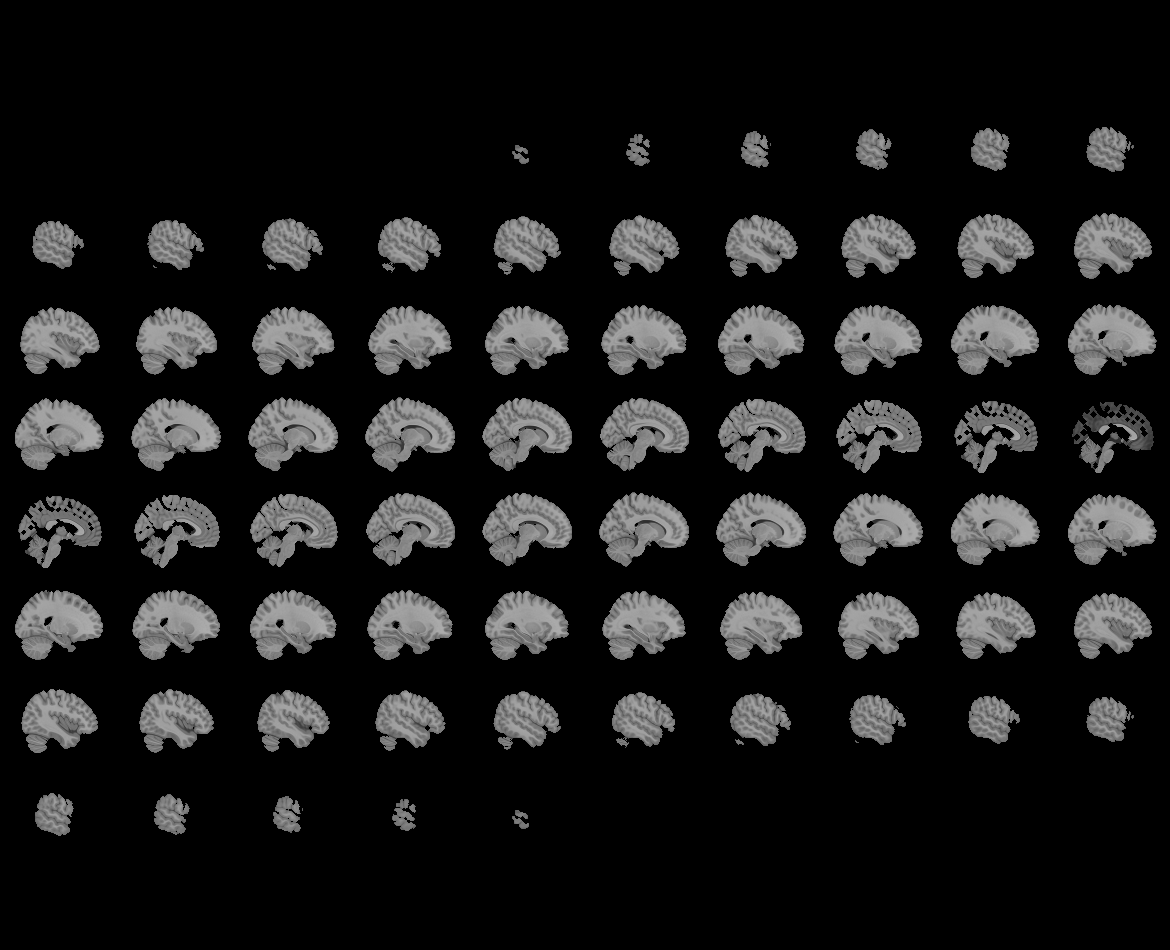
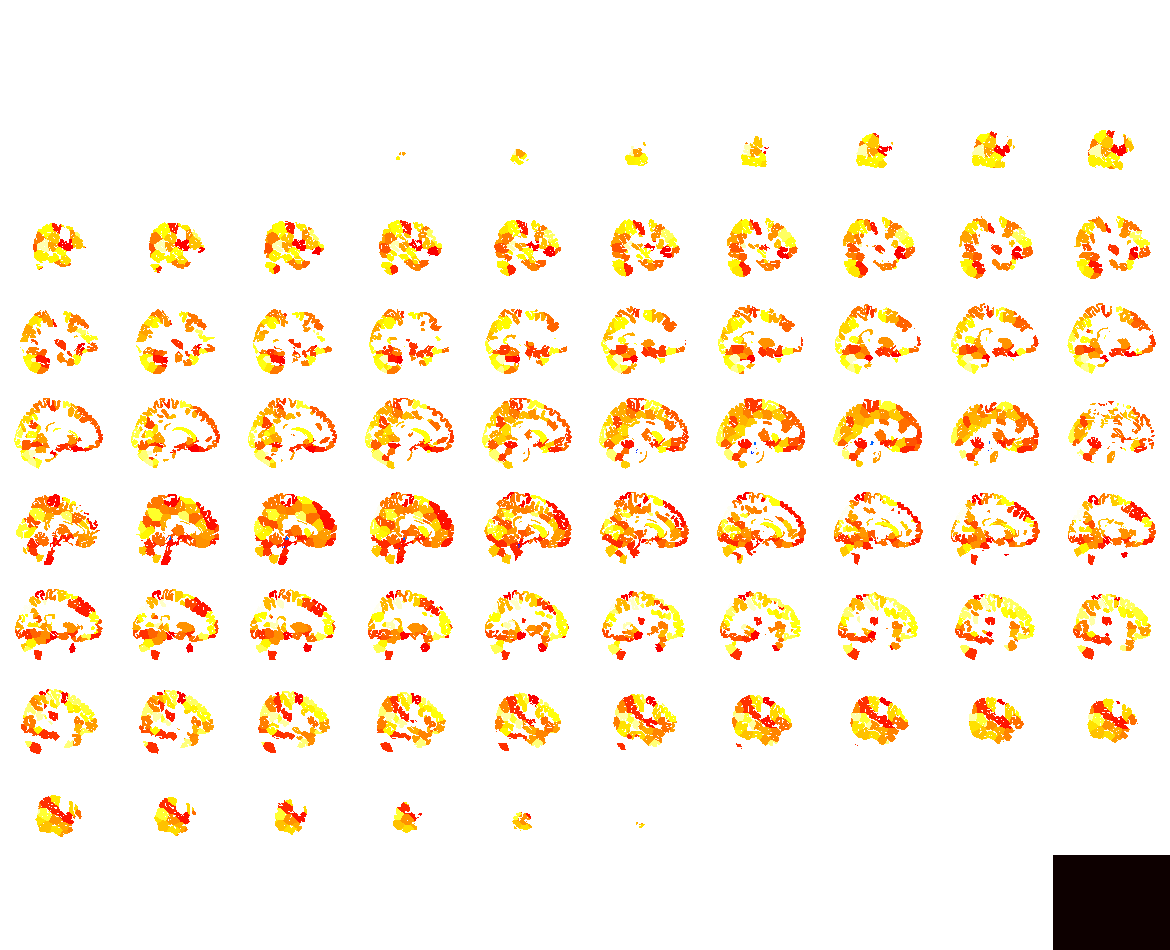

In [20]:
import nilearn.plotting
view = nilearn.plotting.view_img(brainisc, threshold = 0.03)
view

In [37]:
result_df.head()

,ISC,Twin Status
0,0.406846,twin
1,0.253610,twin
2,0.255721,twin
3,0.552928,twin
4,0.228784,twin


In [50]:
df = pd.DataFrame([reg_mean_twin_iscs[:293], reg_mean_controltwin_iscs[:293], reg_mean_notwin_iscs[:293]]).T
df.columns = ['twins', 'control_twins', 'no_twins']
df

,twins,control_twins,no_twins
0,0.098785,0.064853,0.065667
1,0.121026,0.077913,0.075425
2,0.195469,0.146196,0.147506
3,0.088225,0.038925,0.044702
4,0.189220,0.138337,0.146423
...,...,...,...
288,0.000556,0.035886,0.014618
289,0.010104,0.021556,0.009682
290,0.043552,-0.002692,0.029121
291,-0.013512,-0.013670,0.019336


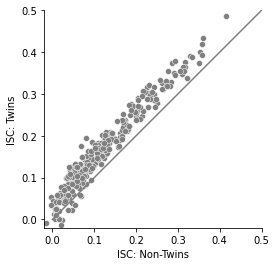

In [80]:
sns.scatterplot(df['no_twins'].values, 
            df['twins'].values,
            color = 'gray')
plt.axis('square');
plt.xlim(-0.02,.5);
plt.ylim(-0.02,.5);

plt.plot([0, 1], [0, 1], color = 'gray')

plt.xticks(ticks=[0, .1, .2, .3, .4,.5])
plt.yticks(ticks=[0, .1, .2, .3 ,.4,.5])

plt.xlabel('ISC: Non-Twins')
plt.ylabel('ISC: Twins')
sns.despine()

<Axes: >

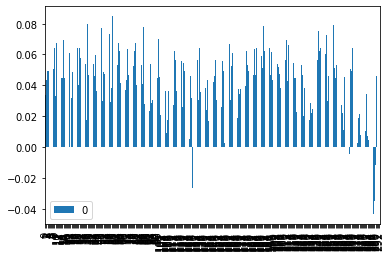

In [66]:
df1 =  pd.DataFrame(df['twins'] - df['control_twins'])
df1.plot(kind="bar")